In [103]:
import tensorflow as tf

In [104]:
import os

In [105]:
import pandas as pd

In [106]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [107]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [108]:
#Getting rid of all the images which cant contribute 
import cv2
import imghdr

In [109]:
train_dir = 'data/train'
val_dir = 'data/validation'
img_height = 56
img_width = 56
img_size=(img_height,img_width)
batch_size = 30

In [110]:
# f = pd.read_csv('data/faceexp-comparison-data-train-public.csv')

In [111]:
image_exts = ['jpeg','jpg','bmp','png']
# os.remove(os.path.join(val_dir,'.DS_store'))
os.listdir(train_dir)

['happy', 'sad', 'fear', 'surprise', 'angry']

In [112]:
for image_class in os.listdir(train_dir): 
    for image in os.listdir(os.path.join(train_dir, image_class)):
        image_path = os.path.join(train_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [113]:
for image_class in os.listdir(val_dir): 
    for image in os.listdir(os.path.join(val_dir, image_class)):
        image_path = os.path.join(val_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [114]:
import numpy as np
from matplotlib import pyplot as plt

In [115]:
# tf.keras??

In [116]:
# tf.keras.preprocessing.image_dataset_from_directory??

In [117]:
# train_data = tf.keras.utils.image_dataset_from_directory(train_dir,image_size=(img_height, img_width))
# val_data = tf.keras.utils.image_dataset_from_directory(val_dir,image_size=(img_height, img_width))

In [118]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=123,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32,
    image_size=img_size,
    shuffle=True,
    seed=123,
)

num_classes = len(train_ds.class_names)
# train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
# val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

Found 23403 files belonging to 5 classes.
Found 5739 files belonging to 5 classes.


In [119]:
# class_names = train_data.class_names
# num_classes = len(class_names)
# print(class_names)

In [120]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [121]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [122]:
# normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))


In [123]:
# # image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [124]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

In [125]:
# len(normalized_ds)

In [154]:
train_size = int(len(train_ds)*.8)
test_size = int(len(train_ds)*.2)

In [155]:
train_size + test_size

780

In [156]:
train = train_ds.take(train_size)
test = train_ds.skip(train_size).take(test_size)

In [157]:
#Building the DNN

In [158]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

In [159]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [160]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [161]:
# model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# model.add(MaxPooling2D())

# model.add(Conv2D(32, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [162]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [163]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 56, 56, 1)         0         
                                                                 
 rescaling_8 (Rescaling)     (None, 56, 56, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 28, 28, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                 

In [164]:
logdir = 'logs'

In [165]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
history = model.fit(train, epochs=20, validation_data=val_ds, callbacks=[tensorboard_callback])

Epoch 1/20
624/624 [==============================] - 18s 28ms/step - loss: 0.9678 - accuracy: 0.6096 - val_loss: 0.9649 - val_accuracy: 0.6107
Epoch 2/20
624/624 [==============================] - 17s 28ms/step - loss: 0.9593 - accuracy: 0.6165 - val_loss: 0.9739 - val_accuracy: 0.6125
Epoch 3/20
624/624 [==============================] - 17s 27ms/step - loss: 0.9477 - accuracy: 0.6222 - val_loss: 0.9771 - val_accuracy: 0.6090
Epoch 4/20
624/624 [==============================] - 17s 27ms/step - loss: 0.9517 - accuracy: 0.6185 - val_loss: 0.9890 - val_accuracy: 0.6017
Epoch 5/20
624/624 [==============================] - 17s 27ms/step - loss: 0.9402 - accuracy: 0.6230 - val_loss: 0.9667 - val_accuracy: 0.6020
Epoch 6/20
624/624 [==============================] - 17s 28ms/step - loss: 0.9298 - accuracy: 0.6265 - val_loss: 0.9632 - val_accuracy: 0.6081
Epoch 7/20
624/624 [==============================] - 17s 28ms/step - loss: 0.9259 - accuracy: 0.6311 - val_loss: 0.9483 - val_accuracy:

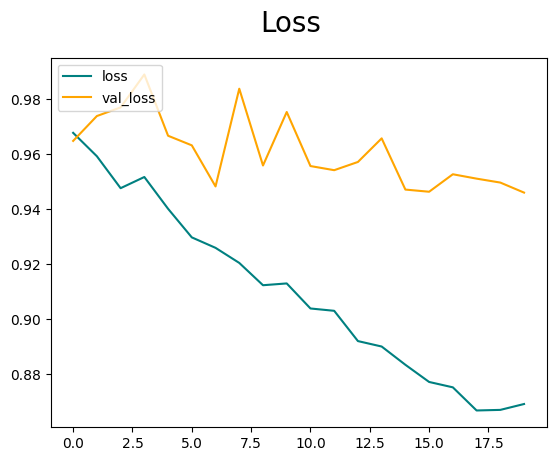

In [168]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

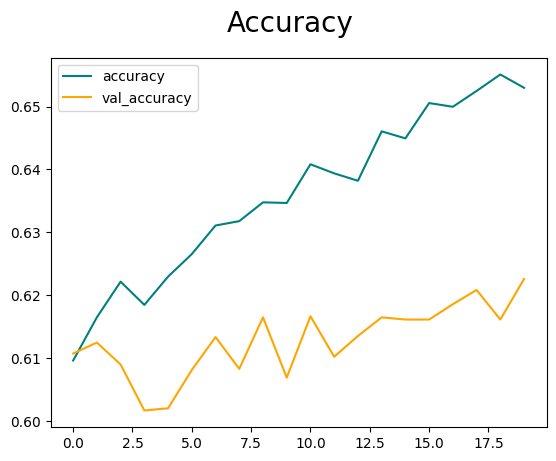

In [169]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [170]:
# Performance Review

In [171]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [172]:
precision = Precision()
recall = Recall()
binAcc = BinaryAccuracy()

In [173]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y,yhat)
    recall.update_state(y,yhat)
    binAcc.update_state(y,yhat)

1/1 [==============================] - 0s 11ms/step


In [174]:
print(f'Precision:{precision.result().numpy()}, {recall.result().numpy()}, {binAcc.result().numpy()}')

Precision:0.48656222224235535, 0.8209757208824158, 0.7909305691719055


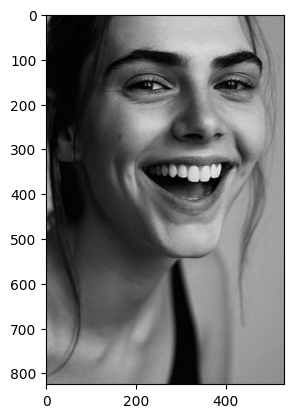

In [145]:
img = cv2.imread('happyTest.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [149]:
happy_dir = "happyTest.jpeg"
img = tf.keras.utils.load_img(
    happy_dir, target_size=(img_height, img_width,),color_mode = 'grayscale'
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

1/1 [==============================] - 0s 194ms/step
[[ 0.9326431  1.6338804 -2.9178572  2.1108437 -2.6087513]]


In [ ]:
resize = tf.image.resize(img, (img_height,img_width))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

In [ ]:
img = cv2.imread('sadTest.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (img_height,img_width))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

In [ ]:
#saving the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','sentimentClassifier.h5'))